This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import itertools
import pandas as pd
import numpy as np

import sys
sys.path.append('/people/jian449/KIM/src')
from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)



# Files/folders/parameters

In [4]:
dir_case = Path("/people/jian449/KIM/examples/im_cloudmodel")
# Training data
dir_data = dir_case / "data"
f_para = dir_data / "PoissonPertb" / "Output.csv"
# Saving folder
dir_results = dir_case / "results-holodec"


In [5]:
# All file locations
# label_set = ['mp-ss-wstd-both-t', 's6', 's20', 's2', 's24']
label_set = ['mp-ss-wstd-both-t', 's2', 's24']
label_plot_set = ['All sensors', 'Sensor 2', 'Sensor 24']
f_state_set, f_kim_set, f_sensi_set = [], [], []
for label in label_set:
    f_state_subset = dir_data / f'Input-{label}.csv'
    f_kim_save = dir_results / f'KIM-{label}'
    f_sensitivity_save = dir_results / f'Data-{label}'

    f_state_set.append(f_state_subset)
    f_kim_set.append(f_kim_save)
    f_sensi_set.append(f_sensitivity_save)


# Load the results

In [6]:
df_para = pd.read_csv(f_para)
y, y_vars = df_para.values, df_para.keys().to_list()
y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30793/1114298432.py:3: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']
/tmp/ipykernel_30793/1114298432.py:3: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


In [7]:
# f_data_save = Path("./results/data")
f_data_save = dir_case / "results/data"
data_set, kim_set = [], []
for i,f_state in enumerate(f_state_set):
    label, f_sensi, f_kim = label_set[i], f_sensi_set[i], f_kim_set[i]
    df_state = pd.read_csv(f_state,  index_col=0)
    x = df_state.values
    logging.info(f'Combination: {label}; total number of keys: {x.shape}.')
    # Preliminary analysis result
    data = Data(x, y)
    data.load(f_sensi)
    # Mapping result
    kim = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')
    # Load the trained mappings
    kim.load(f_kim)
    
    kim_set.append(kim)
    data_set.append(data)


12:20:54 INFO:Combination: mp-ss-wstd-both-t; total number of keys: (513, 1458).
12:20:54 INFO:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
12:20:54 INFO:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
12:20:59 INFO:Combination: s2; total number of keys: (513, 54).
12:21:02 INFO:Combination: s24; total number of keys: (513, 54).


# Post analysis

In [8]:
results = {}
for i,kim in enumerate(kim_set):
    label = label_set[i]
    results[label] = kim.evaluate_maps_on_givendata()

/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divi

## Plot

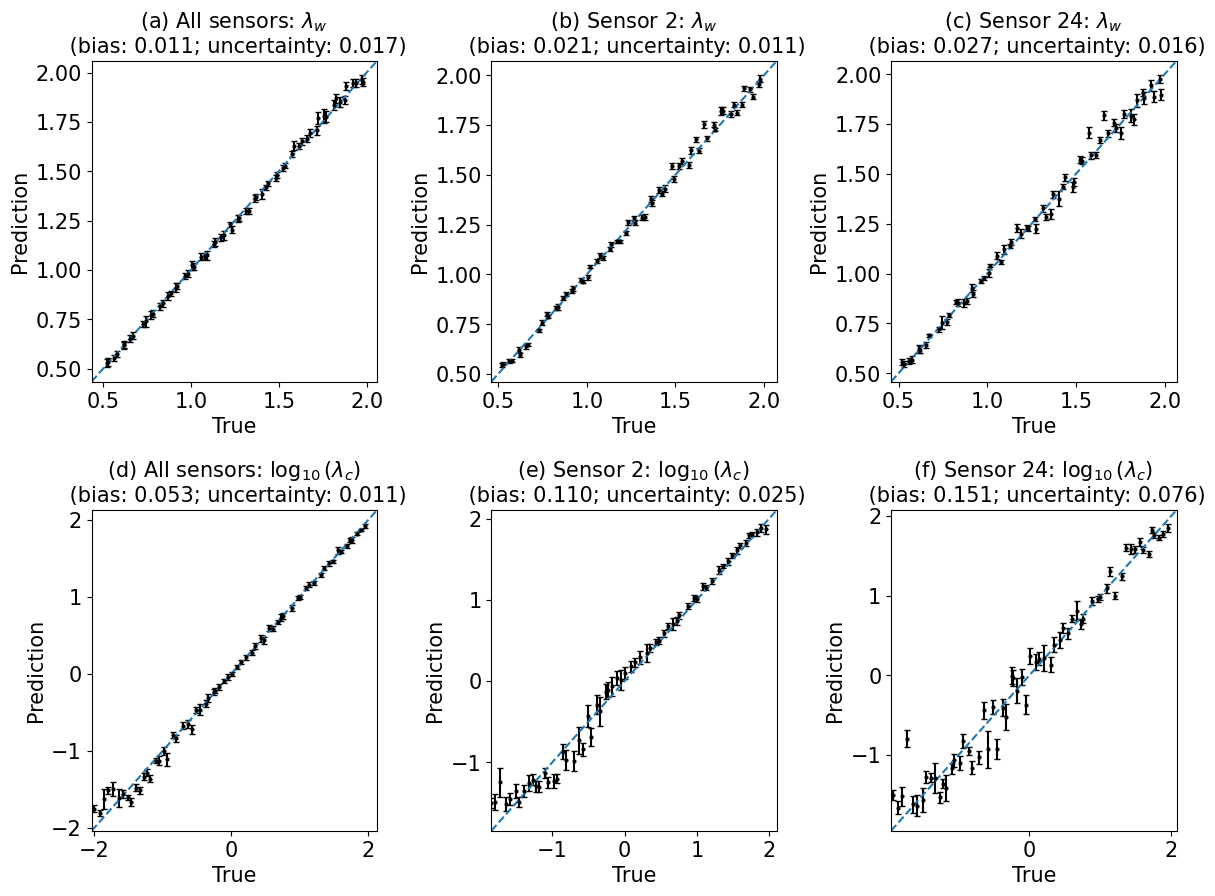

In [11]:
train_or_test = 'test'
# label_set_plot = ['nompR-noss-nowstd-cold', 'nompR-ss-nowstd-warm', 'nompR-ss-nowstd-both', 'nompR-noss-nowstd-cold']
numbers = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
k = 0

fig, axes = plt.subplots(2, len(label_set), figsize=(14,10))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set):
        number = numbers[k]
        model_label = label_plot_set[j]
        kim = kim_set[j]
        r = results[model]
        ax = axes[i,j]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        uncertainty = r['weighted relative uncertainty'][train_or_test][i]

        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_ylim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', 
               title=f"{number} {model_label}: {y_var} \n (bias: {bias:.3f}; uncertainty: {uncertainty:.3f})")
        
        k += 1

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig(f"Performances-holodec-single-sensor.pdf", dpi=300)


## Prediction versus true

In [10]:
# train_or_test = 'test'
# # label_set_plot = ['nompR-noss-nowstd-cold', 'nompR-ss-nowstd-warm', 'nompR-ss-nowstd-both', 'nompR-noss-nowstd-cold']
# label_set_plot = ['mp-ss-wstd-both', 'nompR-noss-nowstd-warm', 'nompR-noss-nowstd-cold', 'nompR-noss-nowstd-both']
# fig, axes = plt.subplots(2,len(label_set_plot),figsize=(20,12))
# for i in range(2):
#     y_var = y_vars[i]
#     for j,model in enumerate(label_set_plot):
#         kim = kim_set[j]
#         r = results[model]
#         ax = axes[i,j]
#         x = r['true'][train_or_test][...,i]
#         y = r['weighted mean predict'][train_or_test][...,i]
#         std = r['weighted std predict'][train_or_test][...,i]
#         bias = r['weighted bias'][train_or_test][i]
#         ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
#         lim = ax.get_xlim()
#         ax.plot(lim, lim, '--', color='tab:blue')
#         ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{y_var} " + "[W m$^{-2}$]")
#         ax.legend()


In [11]:
# train_or_test = 'test'
# label_set_plot = ['nomp-noss-wstd-warm-t', 'nomp-ss-nowstd-warm-not']
# fig, axes = plt.subplots(len(label_set_plot),2,figsize=(12,12))
# for i in range(2):
#     y_var = y_vars[i]
#     for j,model in enumerate(label_set_plot):
#         kim = kim_set[j]
#         r = results[model]
#         ax = axes[j,i]
#         x = r['true'][train_or_test][...,i]
#         y = r['weighted mean predict'][train_or_test][...,i]
#         std = r['weighted std predict'][train_or_test][...,i]
#         bias = r['weighted bias'][train_or_test][i]
#         ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
#         lim = ax.get_xlim()
#         ax.plot(lim, lim, '--', color='tab:blue')
#         ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
#         ax.legend()


In [12]:
# train_or_test = 'test'
# model = 'nomp-ss-wstd-both-t'
# fig, axes = plt.subplots(1,2,figsize=(12,5))
# for i in range(2):
#     y_var = y_vars[i]
#     r = results[model]
#     ax = axes[i]
#     x = r['true'][train_or_test][...,i]
#     y = r['weighted mean predict'][train_or_test][...,i]
#     std = r['weighted std predict'][train_or_test][...,i]
#     bias = r['weighted bias'][train_or_test][i]
#     ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
#     lim = ax.get_xlim()
#     ax.plot(lim, lim, '--', color='tab:blue')
#     ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
#     ax.legend()
# plt.subplots_adjust(wspace=0.3)

In [13]:
# train_or_test = 'test'
# label_set_plot = ['nomp-ss-nowstd-both-t', 'nomp-noss-nowstd-cold-not']
# fig, axes = plt.subplots(len(label_set_plot),2,figsize=(12,12))
# for i in range(2):
#     y_var = y_vars[i]
#     for j,model in enumerate(label_set_plot):
#         kim = kim_set[j]
#         r = results[model]
#         ax = axes[j,i]
#         x = r['true'][train_or_test][...,i]
#         y = r['weighted mean predict'][train_or_test][...,i]
#         std = r['weighted std predict'][train_or_test][...,i]
#         bias = r['weighted bias'][train_or_test][i]
#         ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
#         lim = ax.get_xlim()
#         ax.plot(lim, lim, '--', color='tab:blue')
#         ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
#         ax.legend()
